#### Miguel Chavez, Moneyball Analyis

## The A's Moneyball Period in Major League Baseball
#### The basic idea that Oakland (and other teams) used is to redefine what makes a player good, i.e., figure out what player characteristics translated into wins. Once they realized that teams were not really pricing players using these characteristics, they could exploit this to pay for undervalued players, players that were good according to their metrics, but were not recognized as such by other teams, and therefore not as expensive.

##### This ananlysis will attempt to determine if this technique had a noticeable impact on payroll effeciency for the A's, and how their efficieny compared to other teams during the same timeframe

Data used is from a database on baseball teams, players and seasons curated by Sean Lahman available at [http://www.seanlahman.com/baseball-archive/statistics/](http://www.seanlahman.com/baseball-archive/statistics/). The database has been made available as a `sqlite` database [https://github.com/jknecht/baseball-archive-sqlite](https://github.com/jknecht/baseball-archive-sqlite).

In [26]:
#environment setup and to_mil definition
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 
to_mil = lambda x: x/1000000.0
plt.rcParams.update({'font.size': 18})

## Data Wrangling
### Extracting Relevant Data from sqlite Database into pandas Dataframe

In [27]:
#quering sqlite db to get data for salary and win percentage of all teams from 1990 to 2014
sql_db = sql.connect('2014db.sqlite')
salary_query = "CREATE VIEW IF NOT EXISTS salData AS SELECT yearID, sum(salary) as payroll, teamID FROM Salaries  GROUP BY teamID, yearID ORDER BY yearID"
teams_query = "CREATE  VIEW IF NOT EXISTS teamData AS SELECT G as games, W as wins, L as losses, ((W+.0)/G)*100 as wn_percnt, teamID, yearID, lgID FROM Teams WHERE yearID > 1980"
#sql query to join my teams and salary views, an inner join is used on teamID and yearID, so only teams with entries in both databases will be used
join_query = "CREATE VIEW IF NOT EXISTS joinData as SELECT salData.yearID, salData.teamID, payroll, games, losses, wins, wn_percnt, lgID FROM salData INNER JOIN teamData on teamData.teamID = salData.teamID AND teamData.yearID = salData.yearID"
df_query = "SELECT yearId, teamID, payroll, wn_percnt, wins, games from joinData where yearID >= 1990"
sql_db.execute(teams_query)
sql_db.execute(salary_query)
sql_db.execute(join_query);
#dumping data into df
df = pd.read_sql(df_query, sql_db)

The joinData view created in during execution of the join_query holds an inner join on teamID and yearId between the salary and tea ms table. Since there are missing entries in the teams table, an inner join was used as to only select teams with records in both tables. The df_query used below take selected values needed for later analysis, as well as the team and year identifier for each entry, and places them all in a pandas dataframe.

## Exploratory Data Analysis
### League Payroll Distributions Over Time

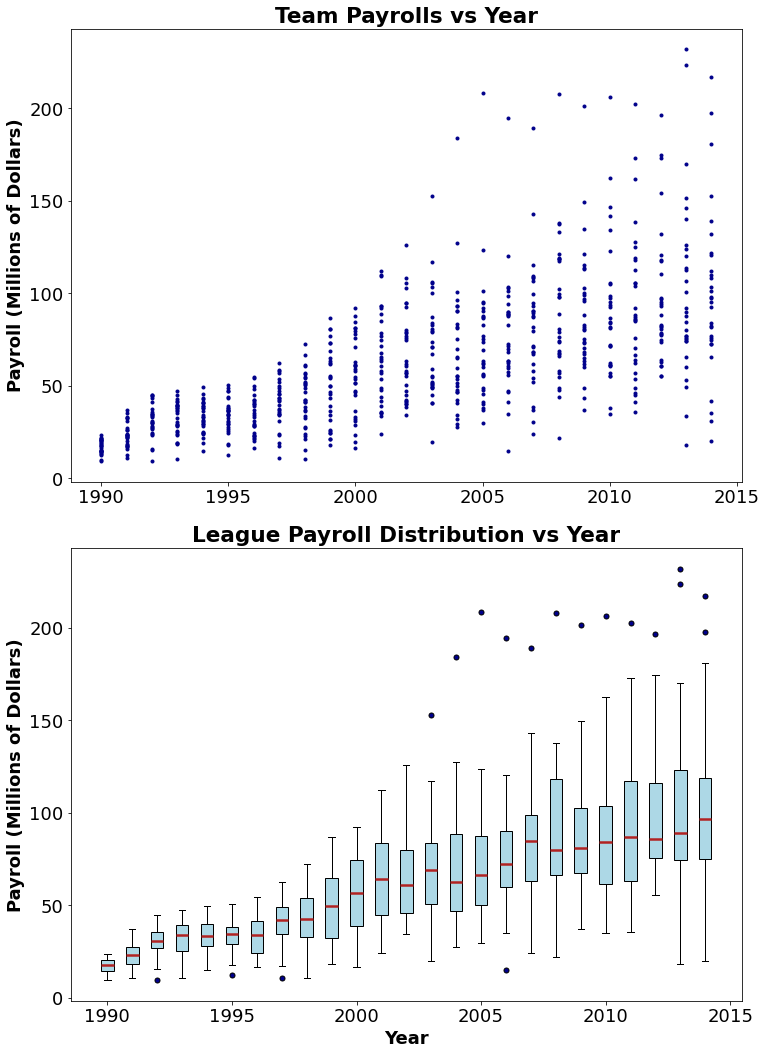

In [28]:
#plotting payroll vs year for all teams
fig1, (ax1,ax2) = plt.subplots(2)
x, y = df['yearID'], df['payroll']
#making dictionary to hold payroll lists to make boxplot
data = {}
for z in df['yearID']:
    data[z] = to_mil(df[df['yearID'] == z]['payroll'])
data = list(data.values())
bplot = ax2.boxplot(data, labels = np.arange(1990,2015), manage_ticks = False, patch_artist = True, 
                    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick'),
                    flierprops = dict(marker='o', markerfacecolor='darkblue', markersize=5, linestyle='none'))
ax1.plot(x, to_mil(y), color = 'darkblue', linestyle = '', marker = '.')
#style code
ax2.set_xlabel('Year', fontweight = 'bold')
ax1.set_ylabel('Payroll (Millions of Dollars)', fontweight = 'bold')
ax2.set_ylabel('Payroll (Millions of Dollars)', fontweight = 'bold')
ax1.set_title('Team Payrolls vs Year', fontweight = 'bold')
ax2.set_title('League Payroll Distribution vs Year', fontweight = 'bold')
ax2.set_xticks(np.arange(1,27,5))
ax2.set_xticklabels(['1990','1995','2000','2005','2010', '2015'])
for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
fig1.set_size_inches(11,15)
fig1.tight_layout()

### Visual Exploratory Analysis
From a preliminary visual analysis of all team payrolls over time, a few observations immediately stand out. First, from 1990 to 2014 the central tendency clearly seems to have increased, and secondly, the distributions seem to have an increasing amount of high flying values in later years, while outliers on the lower side seem to be less prevalent and dramatic. This is likely skewing the mean higher above the median. Plotting the league median and mean over time will allow a clearer view of the positive trend, and plotting the ratio will show how skewed the mean becomes as a result of the large outliers.

### Confirmation of Visually Identified Trends

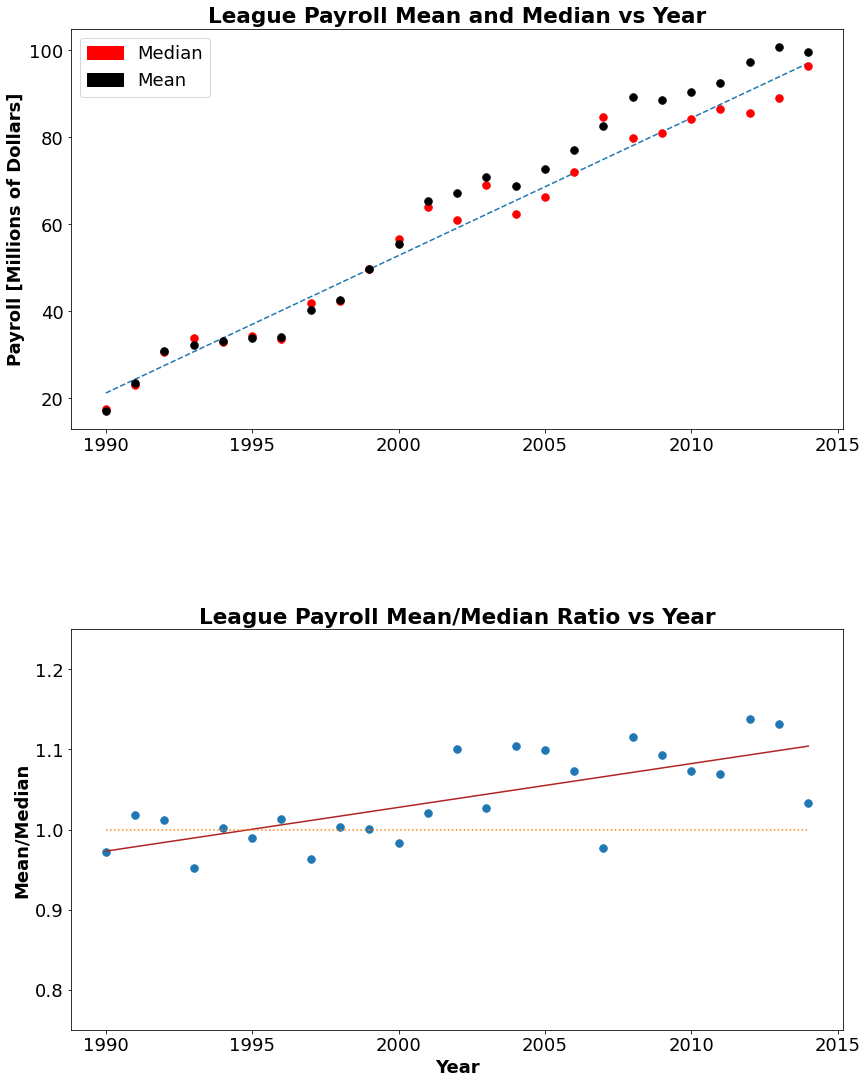

In [29]:
#pivot dataframe on yearID- columns hold teams and their payrolls, indexed by year to make a time based dataframe
df_tb = df.pivot(index = 'yearID', columns = 'teamID', values = 'payroll')
df_tb['median'] = df_tb.median(axis = 1)
df_tb['mean'] = df_tb.mean(axis = 1)
df_tb['std'] = df_tb.std(axis = 1)
df_tb = df_tb[ ['median', 'mean', 'std']]
df_tb.columns.name = None
#plotting median and linear fit
fig2, (ax2, ax3) = plt.subplots(2)
x,y = df_tb.index, to_mil(df_tb['median'])
m,b = np.polyfit(x,y,1)
ax2.plot(x,m*x+b, linestyle = '--')
ax2.plot(x,y,color= 'red', linestyle = '', marker = '.', markersize = 15)
#adding mean
x,y = df_tb.index, to_mil(df_tb['mean'])
ax2.plot(x,y,color = 'black', linestyle = '', marker = '.', markersize = 15)
#creating second plot of mean/median
x,y = df_tb.index, df_tb['mean']/df_tb['median']
ax3.plot(x,y,linestyle = '', marker = '.', markersize = 15)
m,b = np.polyfit(x,y,1)
ax3.plot(x, m*x + b, color = 'firebrick')
#style code
ax3.plot(df_tb.index, np.ones(len(df_tb.index)), linestyle = ':')
fig2.tight_layout()
fig2.set_size_inches(14,18)
redKey = mpatches.Patch(color='red', label='Median')
blackKey = mpatches.Patch(color='black', label='Mean')
ax2.legend(handles = [redKey,blackKey])
ax2.set_title('League Payroll Mean and Median vs Year', fontweight = 'bold')
ax2.set_ylabel('Payroll [Millions of Dollars]', fontweight = 'bold')
ax3.set_title('League Payroll Mean/Median Ratio vs Year', fontweight = 'bold')
ax3.set_ylim([.75, 1.25])
ax3.set_ylabel('Mean/Median', fontweight = 'bold')
ax3.set_xlabel('Year', fontweight = 'bold');

##### As demonstrated by the above figures, the mean and median payroll has steadily increased over time. Furthermore,  plotting the ratio in the second figure shows that between 2001 and 2014 (inclusive), the mean was skewed higher than the median all but one year, and a linear fit on this data shows the trend increasing towards more divergent means over time.

## Data Transformatioins
### Discretizing Years Into Bins

Data will be now be discretized into five bins, and each team's average payroll and winning percentage will be calculated for that time period.

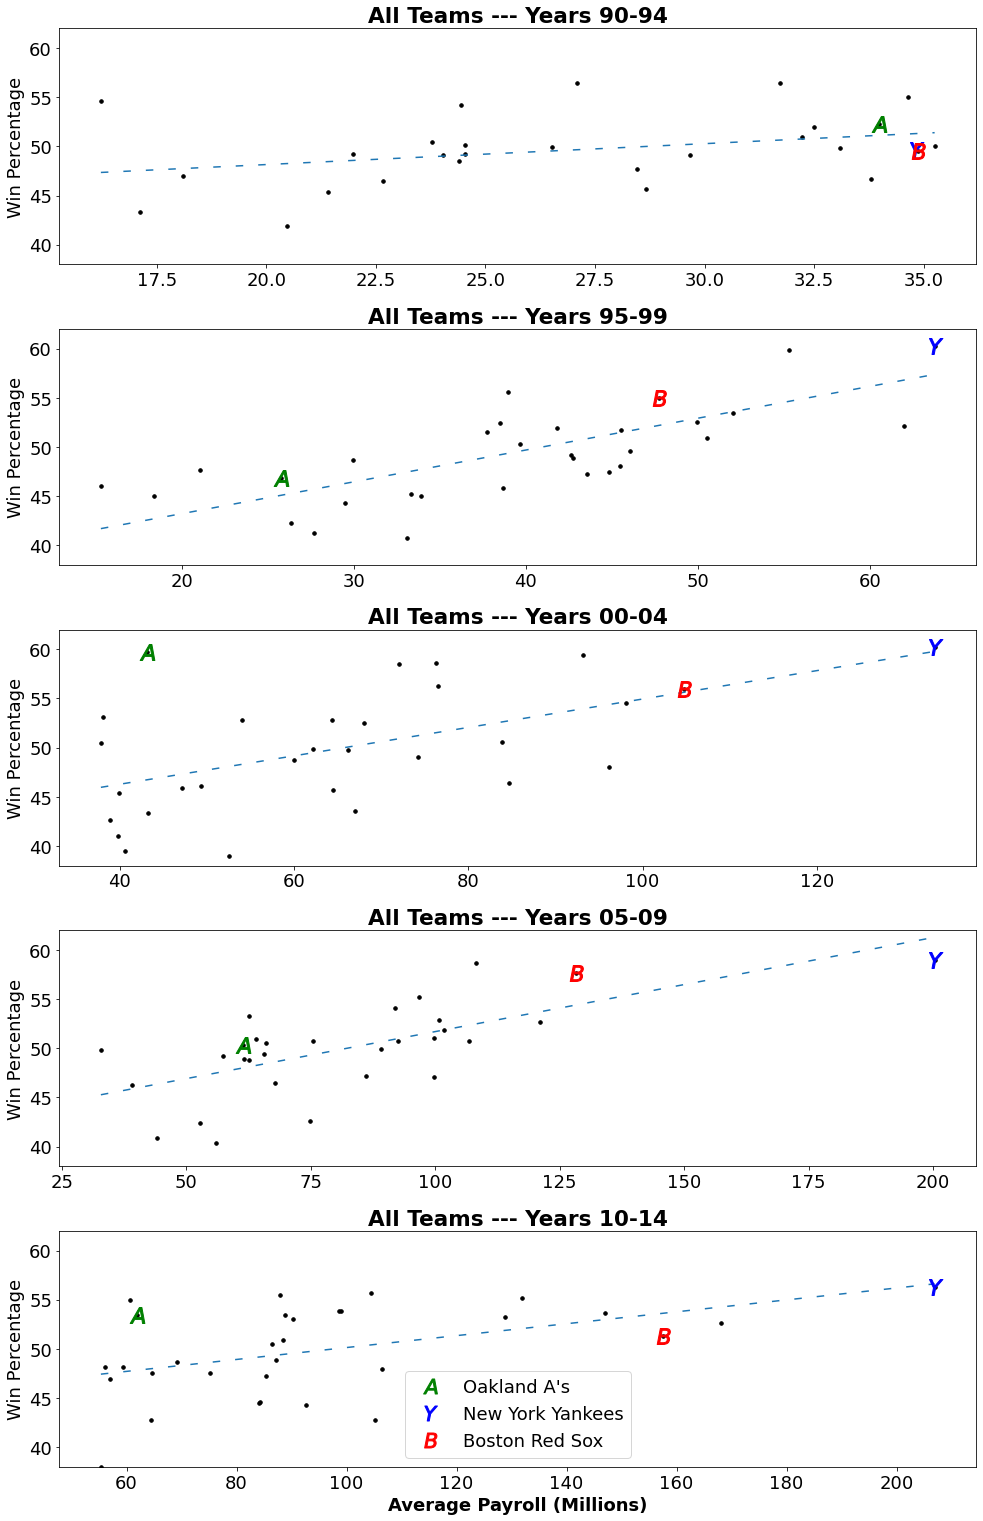

In [30]:
labels = ['90-94', '95-99', '00-04', '05-09','10-14']
df['bin'] = pd.cut(df['yearID'], 5, labels = labels)
#making new df, grouping data by one of 5 bins and team to get average by team, by time period
binsDf = df.groupby(['bin', 'teamID'] ).mean().reset_index().dropna(0).sort_values('payroll')
#plotting all five bins at once
fig3, (ax4, ax5, ax6, ax7, ax8) = plt.subplots(5)
plots = [ax4, ax5, ax6, ax7, ax8]
moneyballKey = mlines.Line2D([], [], color='green', marker='$A$', linestyle='None',
                          markersize=15, label='Oakland A\'s')

yanksKey = mlines.Line2D([], [], color='blue', marker='$Y$', linestyle='None',
                          markersize=15, label='New York Yankees')
bosKey = mlines.Line2D([], [], color='red', marker='$B$', linestyle='None',
                          markersize=15, label='Boston Red Sox')
#function to plot all 5 bins, defined to be reused later with standardized payrolls
def plot_bins(plots, labels, var):
    for c,l in zip(plots, labels):
        #where c is the subplot to operate on and l is the name of the bin, defined above'
        #payroll vs win percent for each team + linear fit
        x,y = to_mil(binsDf[binsDf['bin'] == l][var]), binsDf[binsDf['bin'] == l]['wn_percnt']
        m,b = np.polyfit(x,y,1)
        c.plot(x,y, linestyle = '', marker = '.', markersize = 7, color = 'black')
        c.plot(x, m*x +b, linestyle = (0,(5,10)))
        #repeat process starring only values of Oakland A's
        justOak = binsDf[(binsDf['bin'] == l) & (binsDf['teamID'] == 'OAK')]
        x,y = to_mil(justOak[var]), justOak['wn_percnt']
        c.plot(x,y, linestyle = '', marker = '$A$', markersize = 16, color = 'green')
        #repeat process starring only values of Yankees
        justYanks = binsDf[(binsDf['bin'] == l) & (binsDf['teamID'] == 'NYA')]
        x,y = to_mil(justYanks[var]), justYanks['wn_percnt']
        c.plot(x,y, linestyle = '', marker = '$Y$', markersize = 16, color = 'blue')
        #repeat process starring only values of red sox
        justBos = binsDf[(binsDf['bin'] == l) & (binsDf['teamID'] == 'BOS')]
        x,y = to_mil(justBos[var]), justBos['wn_percnt']
        c.plot(x,y, linestyle = '', marker = '$B$', markersize = 16, color = 'red')
        #style code
        c.set_ylabel('Win Percentage')
        c.set_title('All Teams --- Years ' + l, fontweight = 'bold')
        if c == plots[len(plots)-1]:
            c.set_xlabel('Average Payroll (Millions)', fontweight = 'bold')
            c.legend(handles = [moneyballKey, yanksKey, bosKey], loc = 'lower center')
        c.set_ylim([38, 62])
plot_bins(plots,labels, 'payroll')
#style code
fig3.set_size_inches(14,22)
fig3.tight_layout()
fig3.subplots_adjust(top=0.95)
##fig3.suptitle("Average Payroll vs Win Percentage for Selected Years", fontweight = 'bold' )

### Analysis of Discretized Data
While a postive trend was developed between payroll and win percentage in each timeframe, the trend was poorly defined in the first time period. The spread around the trend generally tightens in the later timeframes, and the values seems to have stronger positve correlation. 1990-1994 was especially bad for GM's, as payroll seems to be only slightly correlated to win percentage. 

The Oakland A's Moneyball period is a clear outlier in the 2000-2004 time period, achieving an average win percentage of almost 60% with an average salary cap less than one third that of the Yankees. The Yankees, as the richest team in the league have consistently performed well since 1995 - but clearly pay quite a premium for their wins. The Red Sox, also quite rich, followed a similiar pattern, but clearly outperformed on an efficiency basis between 2005 and 2009.
## Standardizing Payroll Across Years
To more accurately analyze year-by-year performance, a standardized payroll variable will be calculated, conditioning payroll on the league's spending for that year.
### $$ standardized\_payroll_{ij} = \frac{{payroll}_{ij} - \overline{payroll}_{j} }{{s}_{j}} $$

In [31]:
years = np.arange(1990,2015)
#generating a dictionary for mean and std of team payrolls for each year
values = {}
for y in years:
    values[y] = {}
    values[y]['mean'] = df[df['yearID'] == y]['payroll'].mean()
    values[y]['std'] = df[df['yearID'] == y]['payroll'].std() 
#generating standardized payroll
df['stand_payroll'] = df.apply(lambda row: (row['payroll'] -values[row['yearID']]['mean'])/values[row['yearID']]['std'], axis=1)
#using groupby query to bin values, sorting by standardized payroll
binsDf = df.groupby(['bin', 'teamID'] ).mean().reset_index().dropna(0).sort_values('stand_payroll')

### Repeating Discretized Plots Using Standardized Payroll

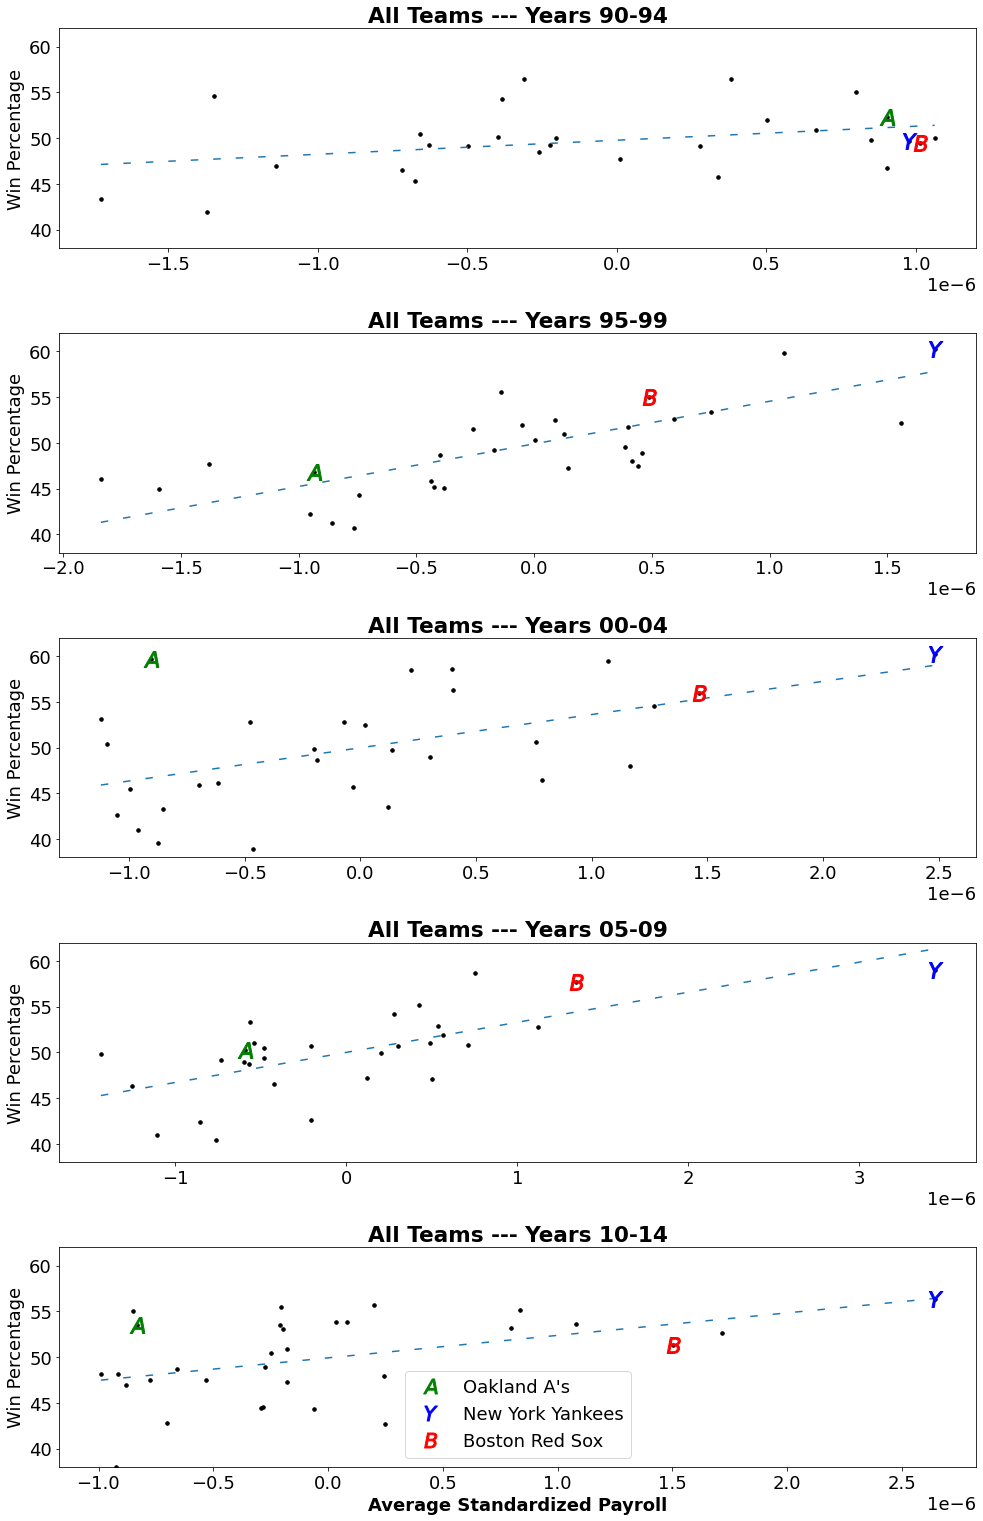

In [32]:
#plotting standardized payrolls
fig4, (ax9, ax10, ax11,ax12,ax13) = plt.subplots(5)
plots = [ax9, ax10, ax11,ax12,ax13]
#using function defined earlier, passing in new plots and now the stand_payroll column
plot_bins(plots,labels, 'stand_payroll')
fig4.set_size_inches(14,22)
fig4.tight_layout()
ax13.set_xlabel('Average Standardized Payroll', fontweight = 'bold')
fig4.subplots_adjust(top=0.95)

### Analysis of Standardized Payroll Plots
 The second set of plots show the same general trends as the first, but the data is more meaningful. The first set of plots use absolute numbers for average payrolls, and payrolls have consistently increased year over year. This results in  years towards the end of each bin having a slightly higher weight than years at the start. Standardizing the payrolls also makes visually identifying the mean payroll easy, as it is where x = 0, where on the original plot there is some guesswork involved.

### Finding Expected Win Percentage Based On Standardized Payroll

Linear Fit = Standardized Payroll*2.725103646155703 + 49.98855314843013


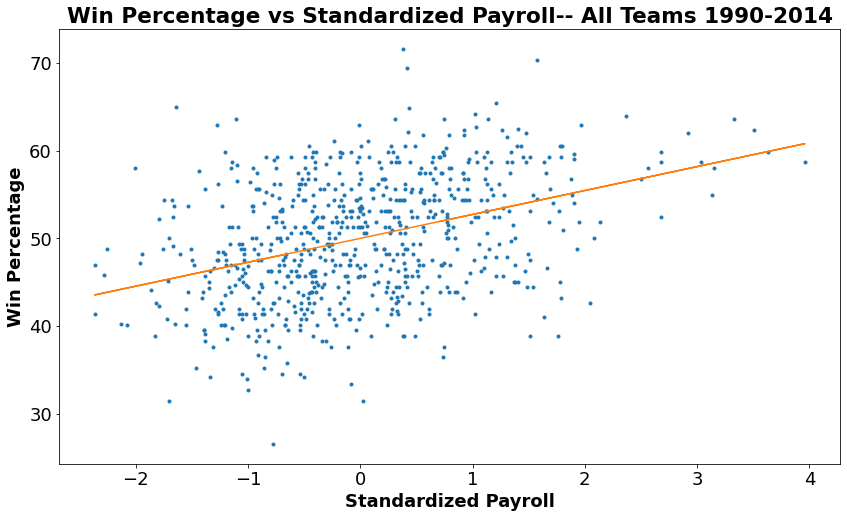

In [33]:
fig5, ax14 = plt.subplots()
#plotting all teams standardized payroll and win percentage
x,y = df['stand_payroll'], df['wn_percnt']
ax14.plot(x,y,linestyle = '', marker = '.')
#adding linear regression
m,b = np.polyfit(x,y,1)
ax14.plot(x,m*x +b, linestyle = '-', marker = '')
#style code
ax14.set_xlabel('Standardized Payroll', fontweight = 'bold')
ax14.set_ylabel('Win Percentage', fontweight = 'bold')
ax14.set_title('Win Percentage vs Standardized Payroll-- All Teams 1990-2014', fontweight = 'bold')
fig5.set_size_inches(14,8)
print("Linear Fit = Standardized Payroll*"+  str(m)+ " + "+ str(b))



### Spending Efficiency and by-Team Continuous  Representation
### $${expected\_win\_percent_{ij} = 50+m_{linFit}×standardized\_payroll_{ij}}$$
### $$efficiency_{ij} = win\_pct_{ij} − expected\_win\_percent_{ij}$$




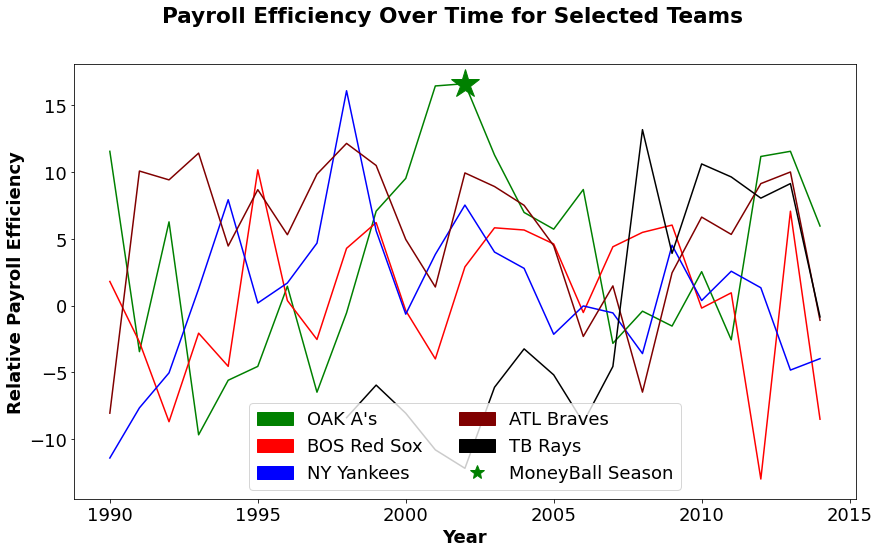

In [34]:
# adding expected win percentage based on standardized payroll and slope of linear fit
df['expected_win_percent'] = 50+ m*df['stand_payroll']
df['efficiency'] = df['wn_percnt'] -df['expected_win_percent']
#plotting efficiency for selected teams
fig5, ax15 = plt.subplots()
colors = ['green', 'red', 'blue', 'maroon', 'black' ]
teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
for c,t in zip(colors,teams):
    x,y = df[df['teamID'] ==t]['yearID'], df[df['teamID'] ==t]['efficiency']
    ax15.plot(x,y,linestyle = '-', marker = '', color = c,)
#labeling moneyball season
moneyball = df[(df['teamID'] == 'OAK') & (df['yearID'] == 2002)]
x,y = moneyball['yearID'], moneyball['efficiency']
#style code
ax15.plot(x,y,linestyle = '', marker = '*',  color = 'green', markersize = 30)
fig5.set_size_inches(14,8)
oakKey = mpatches.Patch(color='green', label='OAK A\'s')
bosKey = mpatches.Patch(color='red', label='BOS Red Sox')
yankKey = mpatches.Patch(color='blue', label='NY Yankees')
atlKey = mpatches.Patch(color='maroon', label='ATL Braves')
tbKey = mpatches.Patch(color='black', label='TB Rays')
ax15.set_xlabel("Year", fontweight = 'bold')
ax15.set_ylabel('Relative Payroll Efficiency', fontweight = 'bold')
fig5.suptitle("Payroll Efficiency Over Time for Selected Teams", fontweight = 'bold')
moneyballKey = mlines.Line2D([], [], color='green', marker='*', linestyle='None',
                          markersize=15, label='MoneyBall Season',)
ax15.legend(handles = [oakKey,bosKey,yankKey,atlKey,tbKey, moneyballKey], loc = 'lower center', ncol = 2);

### By-Year Plot Analysis

Plotting multiple teams over time gives a by year view of efficiency performance for each team, which is not possible with the plots generated by taking the average over multiple years. We can see from the plot that the A's had great efficiency during the Moneyball period, with a win percentage over 15% higher than expected. Also notable are the 2012-2014 Boston Red Sox, showing off a World Series win, sandwiched by two awful seasons. Nuances such as the 2012-2014 Red Sox are impossible to identify on the earlier figures, but immediately stand out when each season is shown continuously. 

